In [1]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


# Robotique : Gym
Dans cette partie nous allons utiliser gym, une librairie permettant de manipuler des environnements physiques facilement en vue d'expérimenter des algorithmes permettant d'apprendre efficacement des politiques.

In [2]:
env = gym.make('CartPole-v1')
observation = env.reset()
total_reward = 0
for t in range(100):
    action = np.random.rand(1,)
    if action > 0:
        action = 1
    else:
        action = 0
    observation, reward, done, info = env.step(action)
    print(observation)
    total_reward += reward
    if done:
        print("Episode finished after %d timesteps" % (t + 1))
        break

[ 0.00261106  0.17547985 -0.00347424 -0.30714054]
[ 0.00612066  0.37065114 -0.00961705 -0.60091713]
[ 0.01353368  0.56590629 -0.02163539 -0.89661368]
[ 0.0248518   0.76131477 -0.03956766 -1.19601811]
[ 0.0400781   0.95692599 -0.06348803 -1.50083514]
[ 0.05921662  1.1527589  -0.09350473 -1.81264564]
[ 0.0822718   1.3487897  -0.12975764 -2.13285768]
[ 0.10924759  1.54493718 -0.1724148  -2.46264726]
[ 0.14014633  1.74104567 -0.22166774 -2.80288772]
Episode finished after 9 timesteps


/home/mohamed/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


On voit bien qu'avec une politique aléatoire le cart tiens seulement 9 timesteps a l'écran.
Dans ce qui suit nous allons entrainer un controller afin de controller le carte et de le faire rester le plus longtemps possible a l'écran.
La structure du controller serra évidente : 
- Etant donné que l'observation se compose de 4 données (position, velocity, angle, velocity du cable) le réseau de neurones prendra ces 4 paramètres en entrée
- La sortie serra tanh et ferra dépendre l'action a prendre
- La fonction d'évaluation serra simplement le reward total cumulé.

In [3]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gen_simplemlp(n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5):
    n_neurons = [n_neurons_per_hidden]*n_hidden_layers if np.isscalar(n_neurons_per_hidden) else n_neurons_per_hidden
    i = Input(shape=(n_in,))
    x = i
    for n in n_neurons:
        x = Dense(n, activation='sigmoid')(x)
    o = Dense(n_out, activation='tanh')(x)
    m = Model(inputs=i, outputs=o)
    return m
    

class SimpleNeuralControllerNumpy():
    def __init__(self, n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5, params=None):
        self.dim_in = n_in
        self.dim_out = n_out
        # if params is provided, we look for the number of hidden layers and neuron per layer into that parameter (a dicttionary)
        if (not params==None):
            if ("n_hidden_layers" in params.keys()):
                n_hidden_layers=params["n_hidden_layers"]
            if ("n_neurons_per_hidden" in params.keys()):
                n_neurons_per_hidden=params["n_neurons_per_hidden"]
        self.n_per_hidden = n_neurons_per_hidden
        self.n_hidden_layers = n_hidden_layers
        self.weights = None 
        self.n_weights = None
        self.init_random_params()
        self.out = np.zeros(n_out)
        #print("Creating a simple mlp with %d inputs, %d outputs, %d hidden layers and %d neurons per layer"%(n_in, n_out,n_hidden_layers, n_neurons_per_hidden))

    
    def init_random_params(self):
        if(self.n_hidden_layers > 0):
            self.weights = [np.random.random((self.dim_in,self.n_per_hidden))] # In -> first hidden
            self.bias = [np.random.random(self.n_per_hidden)] # In -> first hidden
            for i in range(self.n_hidden_layers-1): # Hidden -> hidden
                self.weights.append(np.random.random((self.n_per_hidden,self.n_per_hidden)))
                self.bias.append(np.random.random(self.n_per_hidden))
            self.weights.append(np.random.random((self.n_per_hidden,self.dim_out))) # -> last hidden -> out
            self.bias.append(np.random.random(self.dim_out))
        else:
            self.weights = [np.random.random((self.dim_in,self.dim_out))] # Single-layer perceptron
            self.bias = [np.random.random(self.dim_out)]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def get_parameters(self):
        """
        Returns all network parameters as a single array
        """
        flat_weights = np.hstack([arr.flatten() for arr in (self.weights+self.bias)])
        return flat_weights

    def set_parameters(self, flat_parameters):
        """
        Set all network parameters from a single array
        """
        i = 0 # index
        to_set = []
        self.weights = list()
        self.bias = list()
        if(self.n_hidden_layers > 0):
            # In -> first hidden
            w0 = np.array(flat_parameters[i:(i+self.dim_in*self.n_per_hidden)])
            self.weights.append(w0.reshape(self.dim_in,self.n_per_hidden))
            i += self.dim_in*self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                w = np.array(flat_parameters[i:(i+self.n_per_hidden*self.n_per_hidden)])
                self.weights.append(w.reshape((self.n_per_hidden,self.n_per_hidden)))
                i += self.n_per_hidden*self.n_per_hidden
            # -> last hidden -> out
            wN = np.array(flat_parameters[i:(i+self.n_per_hidden*self.dim_out)])
            self.weights.append(wN.reshape((self.n_per_hidden,self.dim_out)))
            i += self.n_per_hidden*self.dim_out
            # Samefor bias now
            # In -> first hidden
            b0 = np.array(flat_parameters[i:(i+self.n_per_hidden)])
            self.bias.append(b0)
            i += self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                b = np.array(flat_parameters[i:(i+self.n_per_hidden)])
                self.bias.append(b)
                i += self.n_per_hidden
            # -> last hidden -> out
            bN = np.array(flat_parameters[i:(i+self.dim_out)])
            self.bias.append(bN)
            i += self.dim_out
        else:
            n_w = self.dim_in*self.dim_out
            w = np.array(flat_parameters[:n_w])
            self.weights = [w.reshape((self.dim_in,self.dim_out))]
            self.bias = [np.array(flat_parameters[n_w:])]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])
    
    def predict(self,x):
        """
        Propagage
        """
        if(self.n_hidden_layers > 0):
            #Input
            a = np.matmul(x,self.weights[0]) + self.bias[0]
            y = sigmoid(a)
            # hidden -> hidden
            for i in range(1,self.n_hidden_layers-1):
                a = np.matmul(y, self.weights[i]) + self.bias[i]
                y = sigmoid(a)
            # Out
            a = np.matmul(y, self.weights[-1]) + self.bias[-1]
            out = tanh(a)
            return out
        else: # Simple monolayer perceptron
            return tanh(np.matmul(x,self.weights[0]) + self.bias[0])

    def __call__(self,x):
        """Calling the controller calls predict"""
        return self.predict(x)


nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)


In [4]:
def eval_nn(genotype, render=True):
    total_reward=0
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)
    observation = env.reset()
    for t in range(1000):
        if render:
            env.render()
        action=nn.predict(observation)
        if action>0:
            action=1
        else:
            action=0
        observation, reward, done, info = env.step(action)
        total_reward+=reward
        if done:
            print("Episode finished after %d timesteps"%(t+1))
            break
    return -total_reward

In [5]:
import cma.purecma as purecma
nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)
nn.init_random_params()
w = nn.get_parameters()
res = cma.CMAEvolutionStrategy(w, 0.5).optimize(eval_nn,maxfun=10000).result


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 61 (seed=370872, Tue Apr  7 19:28:54 2020)
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.000000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.4
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished a

Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode fin

Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode

Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 13 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 21 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 29 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 16 timesteps
Episode finished after 10 timesteps
Episode finished after 12 timesteps
Episode finished after 11 timesteps
Episode finished after 31 timesteps
Ep

Episode finished after 47 timesteps
Episode finished after 29 timesteps
Episode finished after 107 timesteps
Episode finished after 32 timesteps
Episode finished after 9 timesteps
Episode finished after 17 timesteps
Episode finished after 61 timesteps
Episode finished after 32 timesteps
Episode finished after 27 timesteps
Episode finished after 16 timesteps
Episode finished after 21 timesteps
Episode finished after 55 timesteps
Episode finished after 41 timesteps
Episode finished after 79 timesteps
Episode finished after 31 timesteps
Episode finished after 18 timesteps
Episode finished after 35 timesteps
Episode finished after 123 timesteps
Episode finished after 30 timesteps
Episode finished after 27 timesteps
Episode finished after 40 timesteps
Episode finished after 40 timesteps
Episode finished after 19 timesteps
Episode finished after 14 timesteps
Episode finished after 39 timesteps
Episode finished after 48 timesteps
Episode finished after 54 timesteps
Episode finished after 29 t

Episode finished after 87 timesteps
Episode finished after 50 timesteps
Episode finished after 27 timesteps
Episode finished after 122 timesteps
Episode finished after 19 timesteps
Episode finished after 39 timesteps
Episode finished after 25 timesteps
Episode finished after 102 timesteps
Episode finished after 22 timesteps
Episode finished after 26 timesteps
Episode finished after 59 timesteps
Episode finished after 20 timesteps
Episode finished after 12 timesteps
Episode finished after 83 timesteps
Episode finished after 22 timesteps
Episode finished after 20 timesteps
Episode finished after 27 timesteps
Episode finished after 32 timesteps
Episode finished after 26 timesteps
Episode finished after 38 timesteps
Episode finished after 28 timesteps
Episode finished after 29 timesteps
Episode finished after 32 timesteps
Episode finished after 51 timesteps
Episode finished after 42 timesteps
Episode finished after 87 timesteps
Episode finished after 62 timesteps
Episode finished after 25 

Episode finished after 82 timesteps
Episode finished after 51 timesteps
Episode finished after 55 timesteps
Episode finished after 28 timesteps
Episode finished after 44 timesteps
Episode finished after 33 timesteps
Episode finished after 148 timesteps
Episode finished after 69 timesteps
Episode finished after 50 timesteps
Episode finished after 45 timesteps
Episode finished after 25 timesteps
Episode finished after 56 timesteps
Episode finished after 72 timesteps
Episode finished after 41 timesteps
Episode finished after 30 timesteps
Episode finished after 43 timesteps
Episode finished after 49 timesteps
Episode finished after 28 timesteps
Episode finished after 73 timesteps
Episode finished after 34 timesteps
Episode finished after 211 timesteps
Episode finished after 24 timesteps
Episode finished after 45 timesteps
Episode finished after 36 timesteps
Episode finished after 41 timesteps
Episode finished after 254 timesteps
Episode finished after 33 timesteps
Episode finished after 42

Episode finished after 101 timesteps
Episode finished after 76 timesteps
Episode finished after 41 timesteps
Episode finished after 48 timesteps
Episode finished after 113 timesteps
Episode finished after 70 timesteps
Episode finished after 46 timesteps
Episode finished after 35 timesteps
Episode finished after 48 timesteps
Episode finished after 94 timesteps
Episode finished after 51 timesteps
Episode finished after 43 timesteps
Episode finished after 73 timesteps
Episode finished after 33 timesteps
Episode finished after 71 timesteps
Episode finished after 362 timesteps
Episode finished after 139 timesteps
Episode finished after 65 timesteps
Episode finished after 74 timesteps
Episode finished after 57 timesteps
Episode finished after 47 timesteps
Episode finished after 47 timesteps
Episode finished after 35 timesteps
Episode finished after 33 timesteps
Episode finished after 38 timesteps
Episode finished after 36 timesteps
Episode finished after 75 timesteps
Episode finished after 4

Episode finished after 71 timesteps
  115   1840 -1.100000000000000e+02 1.6e+00 3.77e-01  4e-01  4e-01 0:31.2
Episode finished after 69 timesteps
Episode finished after 143 timesteps
Episode finished after 30 timesteps
Episode finished after 38 timesteps
Episode finished after 53 timesteps
Episode finished after 59 timesteps
Episode finished after 69 timesteps
Episode finished after 34 timesteps
Episode finished after 37 timesteps
Episode finished after 73 timesteps
Episode finished after 44 timesteps
Episode finished after 175 timesteps
Episode finished after 41 timesteps
Episode finished after 54 timesteps
Episode finished after 71 timesteps
Episode finished after 50 timesteps
Episode finished after 82 timesteps
Episode finished after 45 timesteps
Episode finished after 51 timesteps
Episode finished after 38 timesteps
Episode finished after 46 timesteps
Episode finished after 173 timesteps
Episode finished after 101 timesteps
Episode finished after 57 timesteps
Episode finished after

Episode finished after 211 timesteps
Episode finished after 50 timesteps
Episode finished after 72 timesteps
Episode finished after 500 timesteps
Episode finished after 68 timesteps
Episode finished after 63 timesteps
Episode finished after 74 timesteps
Episode finished after 69 timesteps
Episode finished after 236 timesteps
Episode finished after 34 timesteps
Episode finished after 500 timesteps
Episode finished after 34 timesteps
Episode finished after 56 timesteps
Episode finished after 69 timesteps
Episode finished after 50 timesteps
Episode finished after 69 timesteps
Episode finished after 54 timesteps
Episode finished after 40 timesteps
Episode finished after 49 timesteps
Episode finished after 67 timesteps
Episode finished after 32 timesteps
Episode finished after 96 timesteps
Episode finished after 40 timesteps
Episode finished after 146 timesteps
Episode finished after 50 timesteps
Episode finished after 28 timesteps
Episode finished after 154 timesteps
Episode finished after

Episode finished after 164 timesteps
Episode finished after 75 timesteps
Episode finished after 59 timesteps
Episode finished after 59 timesteps
Episode finished after 34 timesteps
Episode finished after 28 timesteps
Episode finished after 32 timesteps
Episode finished after 36 timesteps
Episode finished after 457 timesteps
Episode finished after 36 timesteps
Episode finished after 60 timesteps
Episode finished after 60 timesteps
Episode finished after 28 timesteps
Episode finished after 34 timesteps
Episode finished after 98 timesteps
Episode finished after 31 timesteps
Episode finished after 262 timesteps
Episode finished after 57 timesteps
Episode finished after 27 timesteps
Episode finished after 43 timesteps
Episode finished after 176 timesteps
Episode finished after 51 timesteps
Episode finished after 101 timesteps
Episode finished after 45 timesteps
Episode finished after 66 timesteps
Episode finished after 48 timesteps
Episode finished after 36 timesteps
Episode finished after 

Episode finished after 49 timesteps
Episode finished after 178 timesteps
Episode finished after 46 timesteps
Episode finished after 186 timesteps
Episode finished after 55 timesteps
Episode finished after 47 timesteps
Episode finished after 101 timesteps
Episode finished after 47 timesteps
Episode finished after 42 timesteps
Episode finished after 64 timesteps
Episode finished after 337 timesteps
Episode finished after 47 timesteps
Episode finished after 106 timesteps
Episode finished after 68 timesteps
Episode finished after 43 timesteps
Episode finished after 80 timesteps
Episode finished after 426 timesteps
Episode finished after 448 timesteps
Episode finished after 77 timesteps
Episode finished after 251 timesteps
Episode finished after 328 timesteps
Episode finished after 62 timesteps
Episode finished after 36 timesteps
Episode finished after 31 timesteps
Episode finished after 31 timesteps
Episode finished after 46 timesteps
Episode finished after 48 timesteps
Episode finished af

KeyboardInterrupt: 

# Programmation Génétique :

In [6]:
import math
import random

import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [8]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [11]:



creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def f(x):
    d = x**4 - x**3 + x**2 + np.sin(2*x+3)
    return d

def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    sqerrors = ((func(x) - f(x))**2 for x in points)
    return math.fsum(sqerrors) / len(points),



toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 172, stats=mstats,halloffame=hof, verbose=True)


/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	6.88565	0  	1077.57	0.607941	300   	61.9959	3.62333	0  	7  	2  	300   	1.47923
1  	142   	2.24305	1  	21.5194	0.607941	142   	1.9596 	3.44333	1  	10 	1  	142   	1.51001
2  	148   	2.01115	2  	21.5194	0.472098	148   	2.13087	3.45333	2  	11 	1  	148   	1.75342
3  	158   	1.8451 	3  	21.5194	0.472098	158   	2.33981	3.68667	3  	11 	1  	158   	1.99712
4  	183   	1.58467	4  	21.5194	0.413369	183   	1.73357	4.13   	4  	12 	1  	183   	2.20146
5  	181   	1.76182	5  	49.2511	0.1141  	181   	3.40845	5.28   	5  	14 	1  	181   	2.36677
6  	163   	1.30108	6  	13.8638	0.0157248	163   	1.40081	5.87333	6  	13 	1  	163   	2.18112
7  	168   	1.36772	7  	24.9168	0.0157248	168   	1

89 	177   	0.329842	89 	5.19318	0.0143664	177   	0.753049	32.51  	89 	90 	5  	177   	16.883 
90 	144   	0.225   	90 	6.25488	0.0143664	144   	0.630028	33.27  	90 	80 	5  	144   	17.3907
91 	164   	0.368345	91 	23.7155	0.0143664	164   	1.5774  	33.35  	91 	80 	2  	164   	17.2943
92 	174   	0.310923	92 	17.1957	0.0143664	174   	1.18266 	34.7   	92 	102	5  	174   	18.1418
93 	173   	0.367759	93 	6.25488	0.0143664	173   	0.896019	38.24  	93 	94 	1  	173   	19.5624
94 	176   	0.224245	94 	3.99193	0.0143664	176   	0.584694	41.4333	94 	84 	1  	176   	18.484 
95 	165   	0.23836 	95 	6.45993	0.0143664	165   	0.757029	44.7433	95 	101	5  	165   	18.4865
96 	168   	0.195112	96 	6.86088	0.0143664	168   	0.659359	49.1567	96 	94 	5  	168   	16.231 
97 	154   	0.27069 	97 	6.25488	0.0143664	154   	0.811139	52.6867	97 	97 	5  	154   	15.0739
98 	165   	0.232644	98 	4.33324	0.0143664	165   	0.684392	52.76  	98 	97 	1  	165   	14.4084
99 	170   	0.248442	99 	5.19318	0.0143664	170   	0.65017 	51.9867	99 	

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (5, 6), (5, 7), (7, 8), (8, 9), (8, 10), (7, 11), (4, 12), (12, 13), (12, 14), (14, 15), (15, 16), (16, 17), (16, 18), (18, 19), (19, 20), (19, 21), (15, 22), (22, 23), (22, 24), (24, 25), (25, 26), (26, 27), (26, 28), (25, 29), (29, 30), (29, 31), (31, 32), (32, 33), (33, 34), (34, 35), (34, 36), (36, 37), (37, 38), (37, 39), (33, 40), (40, 41), (40, 42), (42, 43), (42, 44), (44, 45), (44, 46), (31, 47), (47, 48), (47, 49), (49, 50), (24, 51), (14, 52), (52, 53), (52, 54), (54, 55), (54, 56), (0, 57), (57, 58), (57, 59)]
{0: 'mul', 1: 'add', 2: -1, 3: 'sin', 4: 'sub', 5: 'protectedDiv', 6: 'x', 7: 'sub', 8: 'add', 9: 1, 10: 'x', 11: 'x', 12: 'mul', 13: 0, 14: 'add', 15: 'mul', 16: 'add', 17: 'x', 18: 'neg', 19: 'prote

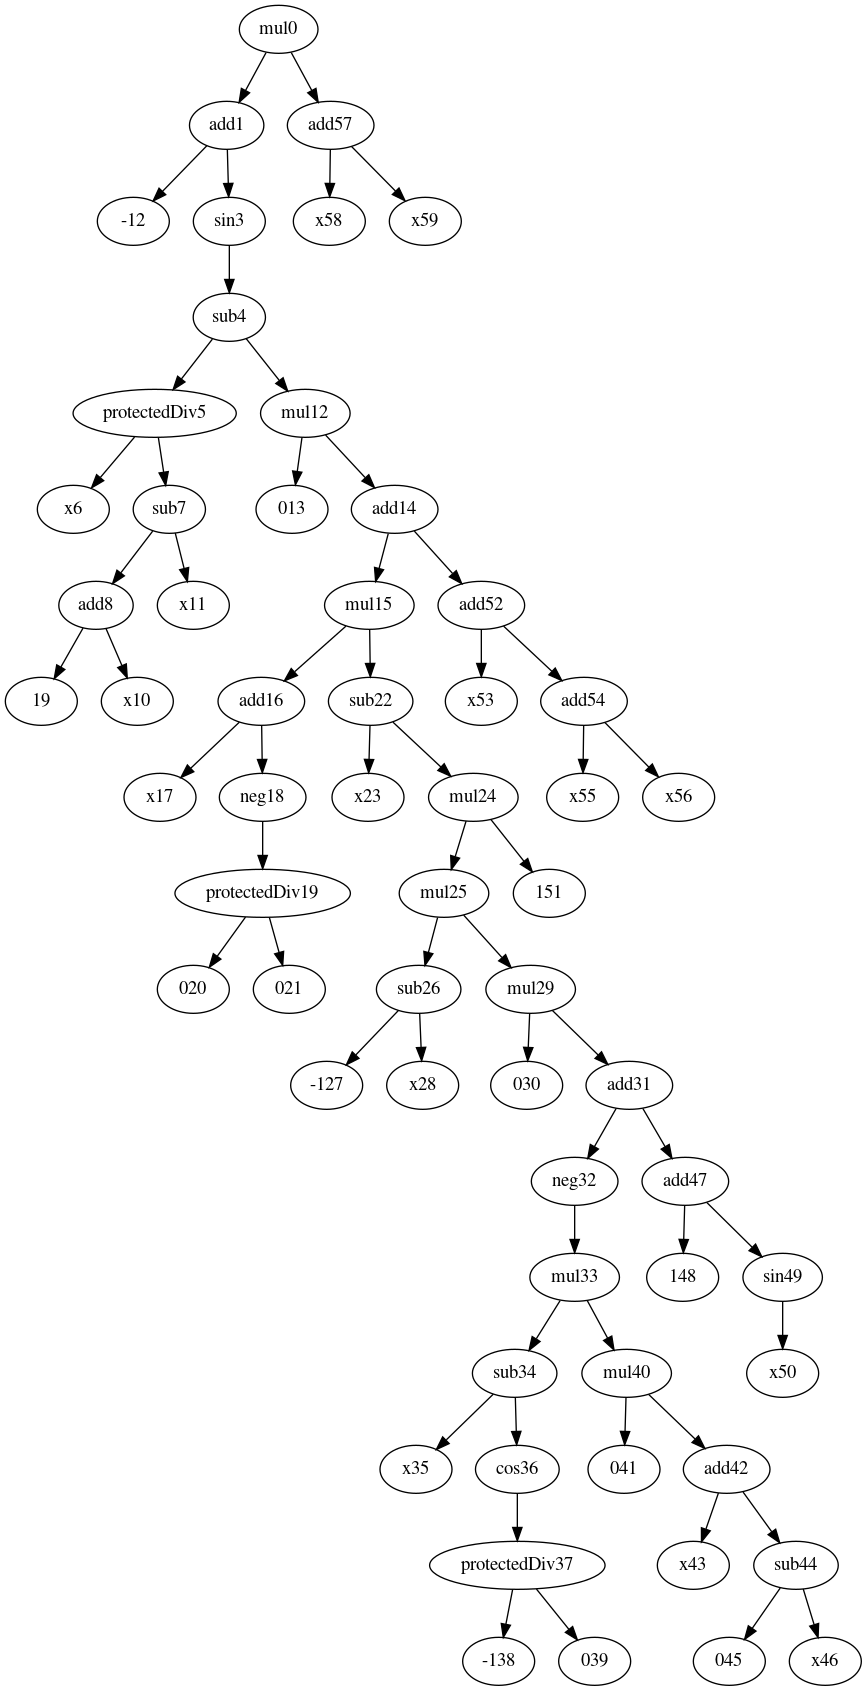

In [12]:
nodes, edges, labels = gp.graph(hof[0])

print(nodes)
print(edges)
print(labels)
sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

Donc le modèle qu'on trouve est :  [[0.33829559 0.0117567 ]]


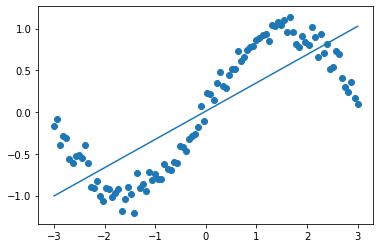

In [13]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def adapt(X):
    return np.hstack((X,np.ones((X.shape[0],1))))  

def predictions(w,x):
    ypredict = np.dot(x,w.T)
    return ypredict

w = np.dot(np.linalg.pinv(adapt(x)),y)
print("Donc le modèle qu'on trouve est : ",w.T)

plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,adapt(x))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

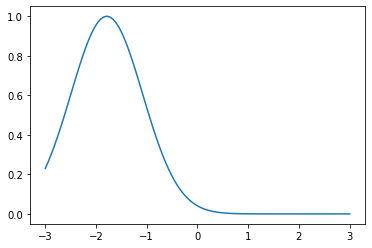

b1 =  (100, 1)
x =  (100, 1)
Donc le modèle qu'on trouve est :  [[-1.21869261 -0.02990309  1.09460428]]


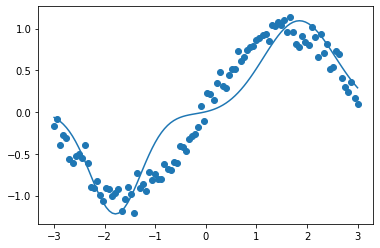

In [14]:
def radial_basis_func(X,center=0.5,widths=1):
    c = X[int(center*X.shape[0])]
    return np.exp(-np.divide(np.square(x - c), widths))

recepient = [(0.2,0.5),(0.5,1),(0.8,1)]

def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def display_recipients(X,reciepients):
    for r in reciepients:
        y = radial_basis_func(X,center = r[0],widths=r[1])
        plt.plot(X,y)
    plt.show()

b1 = radial_basis_func(x,center = 0.2)
plt.plot(x,b1)
plt.show()
print("b1 = ",b1.shape)
print("x = ",x.shape)


w = np.dot(np.linalg.pinv(kernel(x,recepient).T.dot(kernel(x,recepient))),kernel(x,recepient).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,recepient))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

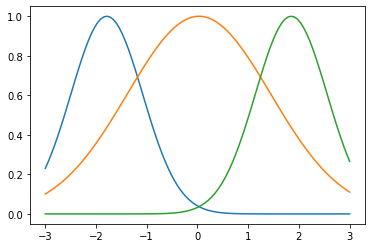

Donc le modèle qu'on trouve est :  [[-1.08060026  0.02294644  1.11739597]]


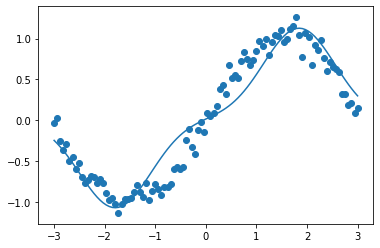

In [15]:
x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

recepient = [(0.2,1),(0.5,4),(0.8,1)]
display_recipients(x,recepient)

w = np.dot(np.linalg.pinv(kernel(x,recepient).T.dot(kernel(x,recepient))),kernel(x,recepient).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,recepient))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

In [16]:
def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def adding_kernel(X,rec):
    H = np.hstack((X,radial_basis_func(X,center = rec[0],widths=rec[1])))
    return H

def identity(x):
    return x

def recipien_generator():
    return tuple([np.random.rand(1)[0],np.random.uniform(1,10)])

pset2 = gp.PrimitiveSetTyped("KERN_MAIN", [np.ndarray],np.ndarray)
pset2.addPrimitive(adding_kernel, [np.ndarray, tuple], np.ndarray)

pset2.addPrimitive(identity, [tuple], tuple)

pset2.addEphemeralConstant("recipient2",recipien_generator , tuple)

pset2.renameArguments(ARG0='x')

In [17]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset2, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset2)

/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [18]:
from sklearn.metrics import mean_squared_error

X = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def eval_kernel(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    K = func(X)
    try:
        w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
        ypred = predictions(w.T,K)
        fitness = mean_squared_error(y,ypred)
    except(np.linalg.LinAlgError):
        fitness = 1e20
    return fitness,



toolbox.register("evaluate", eval_kernel)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




In [19]:
pop = toolbox.population(n=2)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

pop,log= algorithms.eaMuPlusLambda(pop, toolbox, mu=20, lambda_=100, cxpb=0, mutpb=0.3, ngen=200, stats=mstats,halloffame=hof, verbose=True)


   	      	                                 fitness                                 
   	      	-------------------------------------------------------------------------
gen	nevals	avg      	gen	max     	min      	nevals	std      
0  	2     	0.0756099	0  	0.140419	0.0108006	2     	0.0648093
1  	33    	0.036522 	1  	0.140419	0.00877736	33    	0.0519521
2  	25    	0.0101438	2  	0.0108006	0.00877736	25    	0.000884831
3  	20    	0.00937376	3  	0.0108006	0.00877736	20    	0.00085627 
4  	32    	0.00904015	4  	0.0108006	0.00804935	32    	0.000749913
5  	35    	0.0083304 	5  	0.00877736	0.00777372	35    	0.000357705
6  	32    	0.00805024	6  	0.00870485	0.00761051	32    	0.000270066
7  	35    	0.0077851 	7  	0.00795296	0.00760287	35    	0.000137475
8  	29    	0.00774709	8  	0.00808059	0.00760287	29    	0.000160442
9  	32    	0.00762581	9  	0.00777954	0.00756161	32    	5.4671e-05 
10 	36    	0.00760276	10 	0.00763979	0.00756161	36    	1.27829e-05
11 	31    	0.00759935	11 	0.00760391	0.00756161

122	33    	0.00699864	122	0.00700087	0.00699593	33    	2.19539e-06
123	23    	0.00699743	123	0.00700087	0.00699593	23    	1.98401e-06
124	33    	0.00699643	124	0.00700087	0.00699593	33    	1.27162e-06
125	34    	0.00699584	125	0.00699832	0.00699483	34    	6.88224e-07
126	43    	0.0069964 	126	0.00700754	0.00699483	43    	2.66218e-06
127	36    	0.00699552	127	0.00699593	0.00699483	36    	5.05603e-07
128	26    	0.00701944	128	0.00748017	0.00699469	26    	0.000105698
129	28    	0.00699494	129	0.00699587	0.00699469	28    	3.61902e-07
130	26    	0.00699467	130	0.00699483	0.00699376	26    	3.12966e-07
131	17    	0.00699382	131	0.00699483	0.00698517	17    	2.04629e-06
132	21    	0.00699375	132	0.00699483	0.00698517	21    	2.01619e-06
133	33    	0.00699386	133	0.00699469	0.00699323	33    	3.3768e-07 
134	35    	0.00699369	134	0.00699445	0.00699323	35    	2.70696e-07
135	34    	0.00699356	135	0.00699445	0.00699323	34    	3.28712e-07
136	32    	0.00699355	136	0.00699376	0.00699323	32    	2.57773

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (7, 9), (6, 10), (5, 11), (11, 12), (12, 13), (4, 14), (3, 15), (15, 16), (2, 17), (17, 18), (1, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (0, 25), (25, 26)]
{0: 'adding_kernel', 1: 'adding_kernel', 2: 'adding_kernel', 3: 'adding_kernel', 4: 'adding_kernel', 5: 'adding_kernel', 6: 'adding_kernel', 7: 'adding_kernel', 8: 'x', 9: (0.1265850479399766, 2.327836203713053), 10: (0.42120280748061434, 1.41033995499336), 11: 'identity', 12: 'identity', 13: (0.9267813930406644, 2.1238837471832426), 14: (0.5641197545915122, 1.1185730869441497), 15: 'identity', 16: (0.16830842542837476, 1.0487382711015263), 17: 'identity', 18: (0.05996912436975077, 3.022777569748526), 19: 'identity', 20: 'identity', 21: 'identity', 22: 'identity', 23: 'identity', 24: (0.9390449562730602, 9.64518529650977), 25: 'identity', 26: (0.99681644782

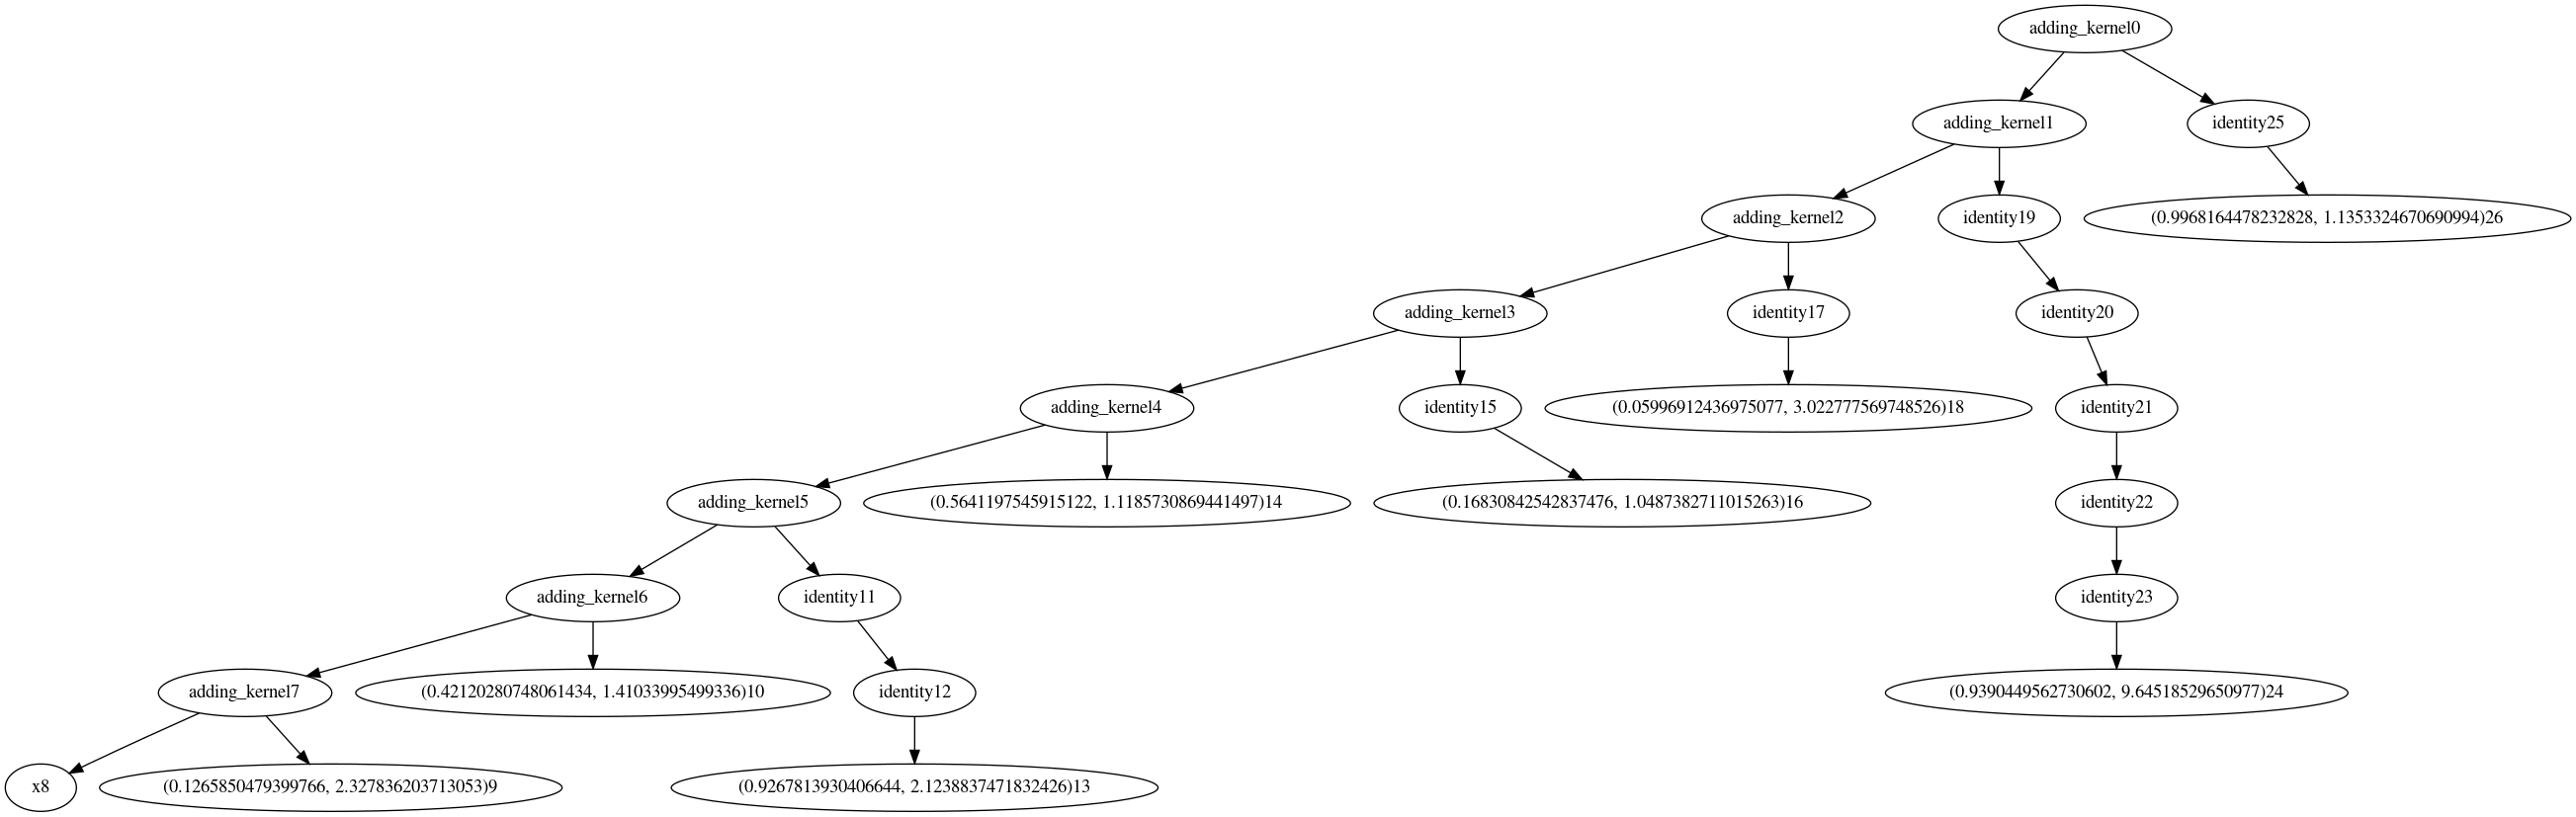

In [20]:
nodes, edges, labels = gp.graph(hof[0])

print(nodes)
print(edges)
print(labels)
sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

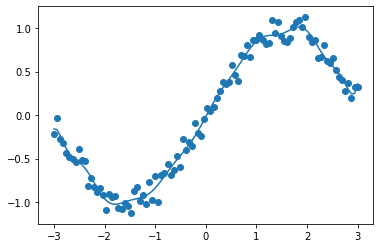

In [21]:
func = toolbox.compile(expr=hof[0])
K = func(X)
w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
#Calcul des prédictions
ypred = predictions(w.T,K)
plt.scatter(X,y)
#Tracage du modèle : 
plt.plot(X,ypred)
plt.show()

# Résolution d'un problème SAT 

In [22]:
from pysat.formula import CNF
import numpy as np


formula = CNF(from_file='input1.cnf')

clause = formula.clauses
L = []
for c in clause:
    L.append(np.array(c))
L = np.array(L)
print(L)

def transform(clause):
    L = []
    for c in clause:
        L.append(np.array(c))
    L = np.array(L)
    return L



def nb_sat(valuation):
    n = 0
    valuation = np.array(valuation)
    for clause in L:
        if(len(clause)!=0):
            a = valuation[clause]
            for c,cl in zip(a,clause):
                if(c == 1 and cl>0):
                    n = n + 1
                    break
                if(c == 0 and cl<0):
                    n = n + 1
                    break
    return n,

def count_clauses():
    n = 0
    for clause in L:
        if(len(clause)!=0):
            n = n + 1
    return n


nb_sat(np.array((formula.nv+1)*[1]))
print(count_clauses())

[array([ 40, -50,  57]) array([ 45,   7, -39]) array([ 24, -42,  26])
 array([25, 29, 56]) array([-16, -28,  35]) array([40,  9, 64])
 array([54, 67, 43]) array([-14, -33, -42]) array([48,  1, 70])
 array([-36,  27,  56]) array([ -8, -53, -33]) array([-32, -52, -47])
 array([ -1,  -7, -14]) array([  9, -18,  65]) array([ 31,  -6, -27])
 array([-35,   8,  17]) array([ 48,  36, -67]) array([ 1, 36, 66])
 array([-3, 11, 54]) array([ 68, -44,  29]) array([-58,  15, -36])
 array([ 14, -56,  75]) array([-65,   1, -71]) array([17, 10, 70])
 array([  1, -68, -46]) array([  3, -62, -35]) array([ 16, -49,  74])
 array([-11, -49,  31]) array([  8,   4, -39]) array([-20,  13,  54])
 array([64, 34, 12]) array([ 22, -52,  54]) array([55, -8, -1])
 array([39,  7, 67]) array([-64,  29, -16]) array([68,  8, -6])
 array([ -9, -53,  18]) array([ 14, -53,  23]) array([-2, 26, 28])
 array([ 71, -16,  66]) array([-58, -50, -17]) array([-29, -62,  25])
 array([61, 62, -1]) array([-29,  -2, -14]) array([ 18, 

In [23]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, formula.nv+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", nb_sat)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=6)

pop = toolbox.population(n=100)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
l=algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=1000,stats=stats)
#l= algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.4, mutpb=0.3, ngen=1000, stats=stats)

/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg  	std    	min	max
0  	100   	283.9	6.58559	266	295
1  	71    	289.43	4.02307	278	297
2  	64    	291.81	4.11751	279	301
3  	61    	295.44	3.65327	286	308
4  	67    	298.78	3.16095	289	308
5  	65    	300.41	3.94232	291	308
6  	55    	303.59	3.63619	293	310
7  	71    	306.17	3.3198 	294	310
8  	70    	307.39	2.52941	299	310
9  	71    	308.81	2.16192	301	314
10 	68    	309.52	2.88957	298	314
11 	72    	310.83	3.2682 	296	314
12 	65    	312.26	3.15157	300	316
13 	50    	313.18	2.32542	300	316
14 	46    	313.6 	2.91204	304	316
15 	59    	314.15	3.22607	303	316
16 	69    	314.6 	3.18748	301	316
17 	69    	314.22	3.23907	302	316
18 	66    	314.68	2.66788	305	316
19 	75    	314.43	3.42419	297	317
20 	72    	314.66	3.74759	297	317
21 	67    	315.32	2.8736 	301	318
22 	73    	315.76	2.6462 	304	318
23 	64    	315.33	3.34382	302	318
24 	68    	315.8 	3.15911	301	318
25 	68    	316.2 	3.41174	303	318
26 	58    	316.28	3.06294	306	318
27 	63    	316.44	3.40388	303	318
28 	70    	316.2

245	74    	320.29	3.60637	304	322
246	64    	320.09	3.98772	304	322
247	67    	319.32	4.74527	300	322
248	63    	320.77	2.94569	309	322
249	64    	320.49	3.2726 	307	322
250	59    	320.12	3.89173	305	322
251	61    	320.39	3.82595	301	322
252	63    	319.9 	3.85616	305	322
253	65    	320.2 	3.87298	306	322
254	63    	320.07	3.71283	305	322
255	70    	320.19	3.52334	303	322
256	65    	320.71	2.87505	310	322
257	68    	319.96	3.59143	308	322
258	67    	319.56	4.01328	304	322
259	59    	320.25	3.60936	306	322
260	72    	320.34	3.18503	309	322
261	69    	320.3 	3.41614	303	322
262	64    	320.5 	3.65377	304	322
263	61    	320.61	3.49255	305	322
264	72    	320.16	3.69519	301	322
265	68    	320.61	2.93222	311	322
266	75    	319.95	3.63696	309	322
267	75    	320.63	3.61844	301	322
268	66    	320.22	3.2514 	309	322
269	59    	319.86	4.1929 	302	322
270	64    	320.22	3.93848	305	322
271	59    	320.63	2.83074	310	322
272	62    	319.98	3.75228	303	322
273	65    	320.17	3.94476	303	322
274	67    	320

488	73    	320.27	3.54078	307	322
489	65    	320.84	2.39883	311	322
490	74    	319.81	3.91074	304	322
491	62    	320.81	2.94175	306	322
492	61    	320.36	3.8145 	305	322
493	52    	321.04	2.46138	309	322
494	59    	319.48	4.84041	299	322
495	74    	319.69	3.80709	307	322
496	61    	319.93	3.91217	304	322
497	63    	320.69	2.94515	307	322
498	64    	320.04	3.66584	303	322
499	57    	320.35	3.54789	305	322
500	68    	319.98	3.46693	309	322
501	64    	319.9 	4.25323	303	322
502	57    	320.52	3.15113	310	322
503	65    	319.74	4.23703	301	322
504	67    	319.98	4.51881	303	322
505	71    	320.48	3.21086	306	322
506	65    	320.3 	3.10322	309	322
507	66    	319.73	4.1276 	305	322
508	67    	319.82	4.02587	306	322
509	70    	319.99	3.9408 	301	322
510	65    	320.6 	3.02324	308	322
511	65    	320.1 	4.10244	301	322
512	65    	320.35	3.00791	311	322
513	64    	320.75	2.92019	306	322
514	66    	319.99	3.86133	308	322
515	68    	320.13	3.79382	302	322
516	58    	319.68	4.34023	304	322
517	66    	320

731	71    	320.79	3.04728	304	322
732	62    	320.28	3.33491	307	322
733	55    	320.73	2.7271 	307	322
734	64    	320.07	3.83211	307	322
735	65    	320.69	2.8555 	310	322
736	56    	320.73	3.11402	309	322
737	72    	320.25	3.40404	305	322
738	59    	320.46	3.37763	305	322
739	59    	320.19	3.73817	307	322
740	66    	320.32	2.94238	307	322
741	70    	320.17	3.47866	309	322
742	65    	320.37	3.23003	309	322
743	74    	320.44	3.24752	307	322
744	59    	320.38	3.54903	306	322
745	57    	320.19	3.58523	307	322
746	70    	320.2 	3.5609 	308	322
747	63    	320.45	3.33579	307	322
748	70    	320.3 	3.5623 	304	322
749	70    	319.98	4.0348 	305	322
750	79    	319.97	3.8248 	306	322
751	76    	320.02	4.02239	307	322
752	65    	319.82	3.76133	306	322
753	69    	320.21	3.51367	306	322
754	69    	320.76	2.804  	311	322
755	63    	320.49	3.33315	306	322
756	67    	320.3 	3.46266	307	322
757	62    	320.81	2.98562	309	322
758	61    	320.36	3.60976	305	322
759	58    	320.03	3.49987	308	322
760	73    	320

976	60    	320.08	4.13928	302	322
977	72    	320.42	3.06979	309	322
978	53    	320.28	3.57793	305	322
979	69    	320.43	3.44167	309	322
980	68    	320.49	3.43364	309	322
981	63    	320.57	2.79018	311	322
982	64    	320.39	3.30422	307	322
983	60    	320.43	3.49358	305	322
984	65    	321.11	2.06347	312	322
985	67    	319.7 	4.20833	307	322
986	58    	320.28	3.3914 	308	322
987	56    	320.63	3.01216	310	322
988	59    	320.03	3.89475	305	322
989	61    	320.58	2.96709	309	322
990	64    	320.67	3.20953	304	322
991	61    	320.28	3.4266 	308	322
992	70    	320.29	3.98069	298	322
993	62    	320.36	3.10973	308	322
994	75    	319.79	3.78496	308	322
995	68    	320.2 	4.03237	298	322
996	70    	320.44	3.05719	310	322
997	66    	320.27	3.21202	305	322
998	63    	320.58	3.36803	305	322
999	58    	320.13	3.64323	306	322
1000	65    	320   	3.86782	303	322


# Utilisation d'une évaluation multi-critère


## Introduction a la décision multi-critères 

    x   y
0  10  12
1  15  11
2   8   8
3  17   5
4   6  18
5   8  12
6  12  16
7  10  17
8  12  10


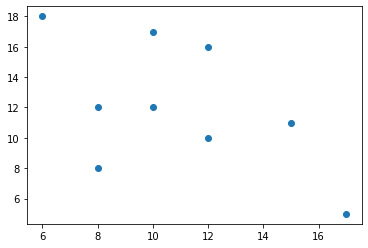

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
datas = [
    dict(
        x = 10,
        y = 12
    ),
    dict(
        x = 15,
        y = 11
    ),
    dict(
        x = 8,
        y = 8
    ),
    dict(
        x = 17,
        y = 5
    ),
    dict(
        x = 6,
        y = 18
    ),
    dict(
        x = 8,
        y = 12
    ),
    dict(
        x = 12,
        y = 16
    ),
    dict(
        x = 10,
        y = 17
    ),
    dict(
        x = 12,
        y = 10
    ),
]
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
df = pd.DataFrame(datas)
print(df)
plt.scatter(X,Y)

In [25]:
def calculer_front(X):
    L = X
    for i in X:
        for j in L:
            if(i["x"] >= j["x"] and i["y"] > j["y"] or i["x"] > j["x"] and i["y"] >= j["y"]):
                L.remove(j)
            if(j["x"] >= i["x"] and j["y"] > i["y"] or j["x"] > i["x"] and j["y"] >= i["y"]):
                L.remove(i)
    return L


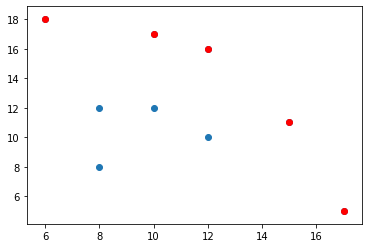

In [26]:
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
plt.scatter(X,Y)
calculer_front(datas)
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
plt.scatter(X,Y,color = "red")
plt.show()


## Algorithmes evolutionnaires Multi-critères NSGA2 et NSGA3

In [29]:
nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)
nn.init_random_params()
w = nn.get_parameters()

creator.create("MaFitness", base.Fitness, weights=(-1.0,-1.0,+2.0))
creator.create("Individual", list, fitness=creator.MaFitness)

toolbox = base.Toolbox()

# à compléter pour sélectionner les opérateurs de mutation, croisement, sélection avec des toolbox.register(...)

# Attribute generator
toolbox.register("attr_float", random.uniform, -2, 2)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, len(w))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxSimulatedBinary, eta = 0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, indpb=0.05, eta = 15, low = -5, up = 5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Les statistiques permettant de récupérer les résultats
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[2])
stats_size = tools.Statistics(lambda ind: -ind.fitness.values[0])
mstats = tools.MultiStatistics(temps=stats_fit, erreur=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("max", numpy.max)
# La structure qui permet de stocker les statistiques
logbook = tools.Logbook()

# La structure permettant de récupérer le meilleur individu
hof = tools.HallOfFame(1)

## à compléter pour initialiser l'algorithme, n'oubliez pas de mettre à jour les statistiques, le logbook et le hall-of-fame.

pop = toolbox.population(n=100)
CXPB, MUTPB = 0.5, 0.2

hof.update(pop)

In [30]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 500
def eval_nn(genotype, render=True, nbstep=500, doPrint = True):
    global errors
    global position
    observation = env.reset()
    total_reward = 0
    total_x=0 # l'erreur en x est dans observation[0]
    total_theta=0 #  l'erreur en theta est dans obervation[2]
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)
    maxXerr = 0
    maxThetaerr = 0
    ti = 0
    observation = env.reset()
    for t in range(nbstep):
        ti = t
        if render:
            env.render()
        action = nn.predict(observation)
        if action > 0:
            action = 1
        else:
            action = 0
        observation, reward, done, info = env.step(action)
        total_x += np.abs(observation[0]-0.2)
        total_theta += np.abs(observation[2])
        if(done):
            break
        if maxXerr < np.abs(observation[0]) :
            maxXerr = np.abs(observation[0])
        if maxThetaerr < np.abs(observation[2]) :
            maxThetaerr = np.abs(observation[2])
    return (total_x/t, total_theta/t, t)

toolbox.register("evaluate", eval_nn)
l=algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=1000,stats=mstats,verbose=True,)



/home/mohamed/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


   	      	                    erreur                    	            temps             
   	      	----------------------------------------------	------------------------------
gen	nevals	avg      	gen	max      	nevals	avg 	gen	max	nevals
0  	100   	-0.224189	0  	-0.100409	100   	9.81	0  	65 	100   
1  	52    	-0.166774	1  	-0.0961722	52    	9.27	1  	45 	52    
2  	68    	-0.172785	2  	-0.0955298	68    	12.78	2  	149	68    
3  	55    	-0.16238 	3  	-0.0881146	55    	17.29	3  	499	55    
4  	57    	-0.153534	4  	-0.0881146	57    	13.93	4  	270	57    
5  	73    	-0.157342	5  	-0.0881146	73    	12.92	5  	345	73    
6  	70    	-0.159486	6  	-0.081262 	70    	12.79	6  	109	70    
7  	60    	-0.155783	7  	-0.0696755	60    	11.43	7  	45 	60    
8  	64    	-0.157626	8  	-0.0718471	64    	14.01	8  	92 	64    
9  	69    	-0.169027	9  	-0.0718471	69    	15.29	9  	147	69    


/home/mohamed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


10 	56    	-0.157993	10 	-0.0932594	56    	15.15	10 	109	56    
11 	69    	-0.162253	11 	-0.0932594	69    	14.04	11 	115	69    
12 	58    	-0.152935	12 	-0.0932594	58    	12.44	12 	118	58    
13 	60    	-0.15451 	13 	-0.0932594	60    	11.85	13 	115	60    
14 	69    	-0.161711	14 	-0.0932594	69    	14.5 	14 	219	69    
15 	63    	-0.161022	15 	-0.100515 	63    	8.97 	15 	44 	63    
16 	57    	-0.156941	16 	-0.100515 	57    	8.93 	16 	51 	57    
17 	59    	-0.157927	17 	-0.100515 	59    	9.62 	17 	71 	59    
18 	63    	-0.157311	18 	-0.100515 	63    	10.59	18 	118	63    
19 	63    	-0.148217	19 	-0.0875624	63    	8.79 	19 	19 	63    
20 	59    	-0.143397	20 	-0.0875624	59    	8.97 	20 	19 	59    
21 	63    	-0.1521  	21 	-0.0875624	63    	9.73 	21 	41 	63    
22 	68    	-0.158818	22 	-0.0875624	68    	16.66	22 	263	68    
23 	67    	-0.14949 	23 	-0.0796637	67    	10.53	23 	128	67    
24 	61    	-0.144194	24 	-0.0796637	61    	9.86 	24 	21 	61    
25 	61    	-0.149441	25 	-0.0796637	61  

KeyboardInterrupt: 